In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from capstone.utils import read_file, get_sectors
from capstone.model_selection import overunder_error, sarimax_exog_cross_val_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from tqdm.auto import tqdm

from warnings import filterwarnings
filterwarnings("ignore")

# Set visualization style and adjust plot settings
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [7]:
sectors = get_sectors()
df = read_file("master_df", index_col=0)

targets = df[sectors]
features = df[df.columns[~df.columns.isin(sectors)]]

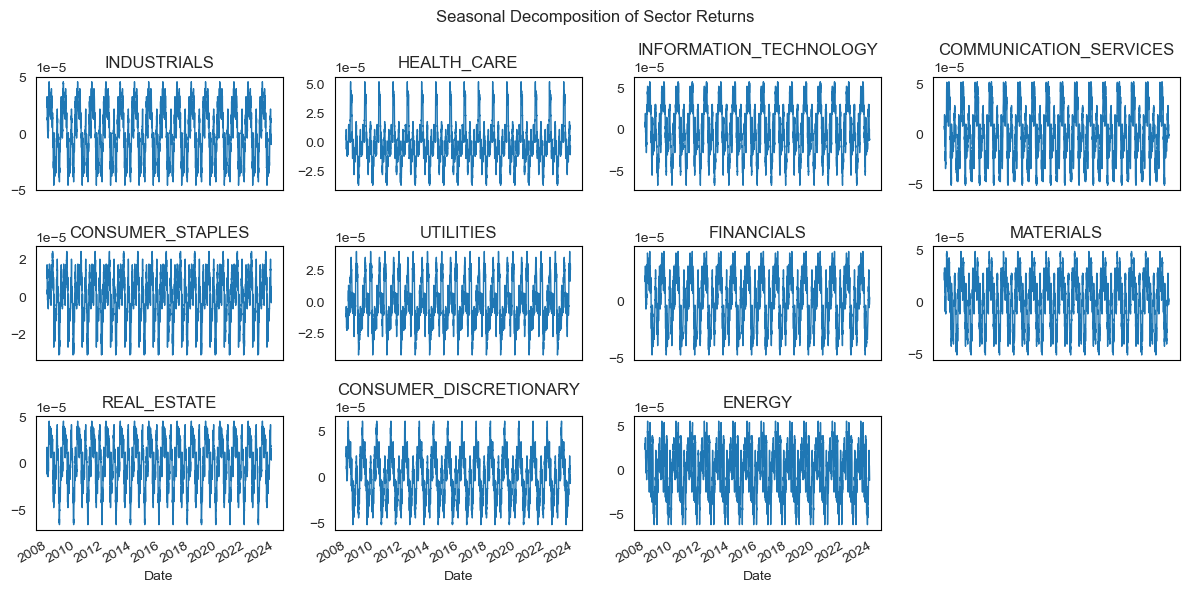

In [8]:
# Perform and visualize seasonal decomposition
fig, axes = plt.subplots(3, 4, figsize=(12,6), sharex=True)
axes = axes.flatten()

# Define the number of trading days in a year
trading_days_per_year = 252

# Loop through each sector to plot its seasonal decomposition
for i, sector in enumerate(sectors):
    axes[i].set_title(sector)
    sector_returns = targets[sector].rolling(trading_days_per_year).mean().dropna()
    
    # Perform seasonal decomposition on the sector returns and plot
    seas_decomp = seasonal_decompose(sector_returns, period=trading_days_per_year)
    seas_decomp.seasonal.plot(ax=axes[i])
    axes[i].grid(False)

axes[-1].axis("off")
fig.suptitle("Seasonal Decomposition of Sector Returns")
plt.tight_layout()

In [10]:
# Define the forecast horizon in terms of trading days per year
forecast = int(trading_days_per_year / 2)

# Shift the features to match the forecast horizon, and drop any missing values
X_shifted = features.shift(forecast).dropna()

# Align the target data with the shifted features
y_all = targets.reindex(X_shifted.index)

# Create a pipeline for standardizing and applying PCA
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=.8, random_state=42))

# Define the SARIMAX orders for ARIMA and seasonal components
order = (1, 0, 1)
s_order = (0, 0, 0, 252)

# Initialize empty DataFrames to store predictions and over-under loss scores
sarimax_preds = pd.DataFrame()
sarimax_ouls = pd.DataFrame()

# Loop through each sector
for sector in tqdm(sectors):
    # Extract the target variable for the current sector
    y = y_all[sector]

    # Loop through the data with a window equal to the forecast horizon
    for i in range(forecast, len(y), forecast):
        
        # Split the data into training and testing sets
        X_train, X_test = X_shifted.iloc[i-forecast:i], X_shifted.iloc[i:i+forecast]
        y_train, y_test = y[i-forecast:i], y[i:i+forecast]

        # Apply PCA to the training and testing feature sets
        X_train_pca = pca_pipe.fit_transform(X_train)
        X_test_pca = pca_pipe.transform(X_test)

        # Perform time-series cross-validation and calculate the mean over-under loss
        mean_oul = np.mean(
            sarimax_exog_cross_val_score(
                X_train,
                y_train,
                order=order,
                seasonal_order=s_order,
                pca=pca_pipe,
                cv=2,
                scorer=overunder_error,
                overpred_penalty=2,
                underpred_penalty=0
            )
        )
        
        # Store the mean over-under loss score
        sarimax_ouls.loc[X_test.index.min(), sector] = mean_oul

        # Fit the SARIMAX model to the training data
        model = SARIMAX(y_train.values, X_train_pca, order=order, seasonal_order=s_order).fit()

        # Generate forecasts for the testing data
        forecast_results = model.get_forecast(steps=len(X_test_pca), exog=X_test_pca)
        y_hat = forecast_results.predicted_mean

        # Store the mean forecasted value
        sarimax_preds.loc[X_test.index.min(), sector] = np.mean(y_hat)

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
sarimax_mean_ouls = pd.DataFrame(sarimax_ouls.mean(axis=1), columns=["SARIMAX"])
sarimax_best_sectors = pd.DataFrame(sarimax_preds.idxmax(axis=1), columns=["SARIMAX"])

In [12]:
sarimax_mean_ouls.to_csv("data/sarimax_mean_ouls.csv")
sarimax_best_sectors.to_csv("data/sarimax_best_sectors.csv")